In [36]:
%matplotlib notebook
import os
import csv
import tikzplotlib
import numpy as np
import pandas as pd
import kmapper as km
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from dunn import dunn_fast
from kmapper import jupyter
from itertools import cycle
from sklearn import metrics
from collections import OrderedDict
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from gensim.models.keyedvectors import KeyedVectors
np.seterr(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None
sns.set_style('whitegrid')

## Load extracted features

In [37]:
DATASET_NAME = "pathcontext"
if not os.path.exists(f"./results/tables/{DATASET_NAME}"):
    os.makedirs(f"./results/tables/{DATASET_NAME}")
if not os.path.exists(f"./results/figures/{DATASET_NAME}"):    
    os.makedirs(f"./results/figures/{DATASET_NAME}")

In [38]:
# Load method names
method_names = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v', sep=" ", dtype=str).iloc[:, 0]
predicted_method_names = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v.predicted_names', sep=" ", dtype=str).iloc[:, 0]
print(len(method_names))

# Load code vectors
vectors = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v.vectors', sep=" ", header=None)
print(len(vectors))

# Load method embeddings
target_embeddings = f'./data/{DATASET_NAME}/targets.txt'
t2v = KeyedVectors.load_word2vec_format(target_embeddings, binary=False)
target_vocab = t2v.vocab.keys()

code_vector_dim = vectors.iloc[0].shape[0]
embedding_dim = 128
print(len(method_names))

51945
51946
51945


In [39]:
# Merge vectors and labels
codevector_df = vectors.assign(method_name=method_names)
codevector_df['predicted_method_name'] = predicted_method_names
# codevector_df.dropna(inplace=True)

# Drop method names which are not contained in the embedding space
codevector_df = codevector_df[codevector_df.method_name.isin(target_vocab)]
method_names = method_names[method_names.isin(target_vocab)]
# method_names

codevector_df

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,method_name,predicted_method_name
0,0.005710,-0.450066,-0.571542,-0.696569,0.036539,-0.338144,0.483433,0.311866,0.335518,0.367954,...,-0.184632,-0.553181,0.873808,0.740360,-0.356890,0.503962,0.749810,0.408294,modelTreeEval,generate|parameters
2,-0.489200,-0.801083,0.795964,-0.532310,-0.422270,-0.928673,0.101660,-0.555703,0.421432,-0.279598,...,-0.626059,0.983307,0.709914,0.424861,0.040801,0.461726,-0.144869,-0.240662,assert|number|of|modes,check|data
4,0.114525,0.966879,0.143578,-0.105650,-0.179169,0.510975,0.100404,0.801753,-0.100849,0.753232,...,-0.723082,0.382389,-0.068426,0.892300,0.567450,-0.247068,0.937158,0.461739,finalize,||init||
6,-0.890873,-0.215420,-0.426521,0.856263,0.981156,0.666914,-0.354285,-0.124023,0.867416,0.812082,...,-0.636986,-0.055931,-0.226563,0.481191,-0.578073,-0.664841,0.756425,-0.799183,|step,||init||
10,-0.218939,0.060387,-0.509713,-0.031471,0.733262,-0.043169,-0.347994,-0.351832,-0.481309,0.382117,...,0.249873,-0.492086,0.463372,-0.321238,0.557794,-0.458229,0.707806,-0.353635,test|fit|proba,||new||
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51939,0.551160,-0.164006,0.421482,-0.153299,0.890327,0.085667,-0.500484,0.379295,0.260082,0.767897,...,-0.547023,-0.426230,0.589060,0.117944,-0.371309,0.713356,0.557111,-0.631464,key|derivation,unpack
51940,-0.340464,0.408252,-0.420419,0.054303,-0.763309,0.233359,-0.622336,-0.066454,-0.084984,0.402718,...,0.619778,-0.287416,0.038232,0.365366,0.077787,0.590351,0.248645,0.139728,predict,||init||
51942,-0.833683,0.931664,0.345059,-0.863327,-0.987379,0.975810,-0.859882,0.833042,-0.493426,-0.870469,...,0.525330,-0.977491,-0.787854,-0.428454,-0.875695,-0.810079,0.168166,0.923468,empty|labels,annotationdb
51943,-0.939577,0.468779,-0.317058,0.072550,-0.975220,0.296472,-0.969066,0.356095,0.686467,-0.894290,...,0.027734,-0.485580,-0.432146,-0.919850,0.506366,0.469264,-0.650506,0.973499,ResNet101,test|delayed


In [11]:
# Create dataframe for method name embeddings
df_inter = pd.DataFrame([{"predicted_method_name": name, "embedding": t2v.get_vector(name)} for name in predicted_method_names])

embeddings = df_inter['embedding'].apply(pd.Series)
embeddings = embeddings.rename(columns = lambda x : 'feat_' + str(x))

method_name_embedding_df = pd.concat([embeddings[:], df_inter[:], method_names], axis=1)
method_name_embedding_df = method_name_embedding_df.rename(columns={method_name_embedding_df.columns[-1]: 'method_name'})
method_name_embedding_df.drop(columns=["embedding"], inplace=True)
method_name_embedding_df.dropna(inplace=True)
method_name_embedding_df.reset_index(drop=True, inplace=True)
method_name_embedding_df

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_120,feat_121,feat_122,feat_123,feat_124,feat_125,feat_126,feat_127,predicted_method_name,method_name
0,-0.204567,-0.316721,-0.262129,0.186071,0.144811,0.048818,0.004780,-0.457620,-0.030724,-0.087152,...,0.498642,-0.266306,0.368414,0.173547,-0.013430,-0.270614,0.290220,0.007404,train,epoch|train
1,-0.345811,-0.155182,-0.137162,0.393843,-0.191419,0.399899,-0.049335,-0.095562,-0.195482,0.411410,...,0.367742,-0.099447,-0.031501,0.305492,-0.206519,-0.255944,0.117646,-0.067576,predict,do|predict
2,-0.131812,0.334108,-0.151816,-0.230827,-0.273653,-0.240113,-0.253736,0.307068,0.239821,0.008727,...,-0.158545,-0.148863,-0.406937,-0.455025,0.067979,0.053165,-0.308003,0.080565,test|forward|stridedslice,test|forward|stridedslice
3,-0.087897,0.285586,0.047934,-0.538411,-0.243282,0.257070,-0.090821,0.262162,0.398067,0.180634,...,-0.349998,0.158877,-0.308520,-0.108633,-0.104936,-0.002643,0.229082,-0.351696,forward|discriminator,forward|discriminator
4,-0.345811,-0.155182,-0.137162,0.393843,-0.191419,0.399899,-0.049335,-0.095562,-0.195482,0.411410,...,0.367742,-0.099447,-0.031501,0.305492,-0.206519,-0.255944,0.117646,-0.067576,predict,predict|row
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,-0.345811,-0.155182,-0.137162,0.393843,-0.191419,0.399899,-0.049335,-0.095562,-0.195482,0.411410,...,0.367742,-0.099447,-0.031501,0.305492,-0.206519,-0.255944,0.117646,-0.067576,predict,predict
2724,-0.214850,-0.034201,-0.041228,0.273891,0.091851,0.262579,0.190917,0.042114,0.076205,0.190650,...,-0.259827,0.437611,0.178807,0.228731,-0.224277,-0.133693,0.213051,-0.046797,forward,predict
2725,-0.214850,-0.034201,-0.041228,0.273891,0.091851,0.262579,0.190917,0.042114,0.076205,0.190650,...,-0.259827,0.437611,0.178807,0.228731,-0.224277,-0.133693,0.213051,-0.046797,forward,forward
2726,-0.059820,0.034176,-0.066867,0.237089,0.134948,-0.238663,0.343406,-0.210490,-0.217489,0.181274,...,0.313063,-0.229422,0.107591,0.183964,0.016572,-0.345012,-0.130539,0.116458,save,save


In [12]:
print(len(method_names))
print(len(codevector_df))
print(len(method_name_embedding_df))

2728
2728
2728


## Data preparation

In [13]:
classes = { 0: 'train', 1: 'save', 2: 'process', 3: 'forward', 4: 'predict' }

# Optional, filter out methods which do not contain any of the chosen classes
method_name_embedding_df = method_name_embedding_df[method_name_embedding_df.method_name.str.contains("|".join(classes.values()))]
codevector_df = codevector_df[codevector_df.method_name.str.contains("|".join(classes.values()))]

# Drop method containing "test" since these generally correspond to test functions written
method_name_embedding_df = method_name_embedding_df[~method_name_embedding_df.method_name.str.contains("test")]
codevector_df = codevector_df[~codevector_df.method_name.str.contains("test")]
codevector_df

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,method_name,predicted_method_name
0,-0.113604,0.377030,0.245518,0.569442,-0.055870,-0.153133,-0.148717,-0.824491,-0.532504,0.479461,...,0.298762,-0.525734,0.381026,0.838534,-0.451254,0.826945,-0.019028,-0.926241,epoch|train,train
1,-0.170432,-0.415908,-0.855380,-0.050435,0.524929,-0.262498,0.683191,-0.540029,0.746246,-0.251934,...,0.236090,0.484947,0.718817,0.701300,0.154008,-0.101269,0.902033,0.425312,do|predict,predict
4,-0.588352,0.623115,0.500140,0.432052,-0.337337,0.546355,-0.328052,0.450513,-0.189792,0.370721,...,0.596091,0.790490,-0.175813,-0.235250,-0.432482,0.611001,-0.218125,-0.648352,forward|discriminator,forward|discriminator
5,-0.932749,0.395356,-0.349202,-0.474137,-0.813022,0.909364,0.112225,0.362530,0.967261,0.907317,...,-0.975094,0.890117,0.121568,0.979238,-0.991646,0.009433,0.969485,-0.947550,predict|row,predict
6,-0.273325,-0.873058,-0.830605,0.946089,-0.289416,0.267266,-0.725831,0.522652,-0.957644,0.454887,...,0.957455,-0.418040,-0.220533,-0.552370,0.962276,-0.333294,-0.831559,0.366939,forward,forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,-0.242680,-0.713093,-0.385580,0.739378,0.381367,0.369221,0.363712,-0.255839,-0.639876,0.613999,...,-0.091930,0.152128,0.391567,0.386280,-0.257682,-0.100188,0.274019,0.055057,predict,predict
3608,-0.017854,-0.323655,-0.574255,-0.183381,0.341164,0.322484,-0.562298,0.017080,0.022063,0.705053,...,-0.156487,-0.054650,-0.056618,-0.007276,-0.334831,0.449143,0.667401,0.166985,predict,forward
3609,-0.822725,-0.610031,-0.367232,0.655372,0.612846,0.672845,0.431668,0.314768,0.267370,0.688323,...,-0.516351,0.706307,-0.270619,0.730019,-0.706453,0.466766,0.812490,0.659328,forward,forward
3610,-0.934633,0.694301,-0.457065,0.985924,0.902768,0.489980,0.959953,-0.619946,0.622597,0.935797,...,-0.662698,0.845251,0.923995,0.950671,-0.950861,0.978244,0.978228,-0.986664,save,save


In [14]:
# Assign categories based on method name
method_name_embedding_df['category'] = method_name_embedding_df.method_name.map(lambda x: np.array([x.find(s) for s in classes.values()]).argmax())
codevector_df['category'] = codevector_df.method_name.map(lambda x: np.array([x.find(s) for s in classes.values()]).argmax())
method_name_embedding_df

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_121,feat_122,feat_123,feat_124,feat_125,feat_126,feat_127,predicted_method_name,method_name,category
0,-0.204567,-0.316721,-0.262129,0.186071,0.144811,0.048818,0.004780,-0.457620,-0.030724,-0.087152,...,-0.266306,0.368414,0.173547,-0.013430,-0.270614,0.290220,0.007404,train,epoch|train,0
1,-0.345811,-0.155182,-0.137162,0.393843,-0.191419,0.399899,-0.049335,-0.095562,-0.195482,0.411410,...,-0.099447,-0.031501,0.305492,-0.206519,-0.255944,0.117646,-0.067576,predict,do|predict,4
3,-0.087897,0.285586,0.047934,-0.538411,-0.243282,0.257070,-0.090821,0.262162,0.398067,0.180634,...,0.158877,-0.308520,-0.108633,-0.104936,-0.002643,0.229082,-0.351696,forward|discriminator,forward|discriminator,3
4,-0.345811,-0.155182,-0.137162,0.393843,-0.191419,0.399899,-0.049335,-0.095562,-0.195482,0.411410,...,-0.099447,-0.031501,0.305492,-0.206519,-0.255944,0.117646,-0.067576,predict,predict|row,4
5,-0.214850,-0.034201,-0.041228,0.273891,0.091851,0.262579,0.190917,0.042114,0.076205,0.190650,...,0.437611,0.178807,0.228731,-0.224277,-0.133693,0.213051,-0.046797,forward,forward,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,-0.345811,-0.155182,-0.137162,0.393843,-0.191419,0.399899,-0.049335,-0.095562,-0.195482,0.411410,...,-0.099447,-0.031501,0.305492,-0.206519,-0.255944,0.117646,-0.067576,predict,predict,4
2724,-0.214850,-0.034201,-0.041228,0.273891,0.091851,0.262579,0.190917,0.042114,0.076205,0.190650,...,0.437611,0.178807,0.228731,-0.224277,-0.133693,0.213051,-0.046797,forward,predict,4
2725,-0.214850,-0.034201,-0.041228,0.273891,0.091851,0.262579,0.190917,0.042114,0.076205,0.190650,...,0.437611,0.178807,0.228731,-0.224277,-0.133693,0.213051,-0.046797,forward,forward,3
2726,-0.059820,0.034176,-0.066867,0.237089,0.134948,-0.238663,0.343406,-0.210490,-0.217489,0.181274,...,-0.229422,0.107591,0.183964,0.016572,-0.345012,-0.130539,0.116458,save,save,1


In [15]:
method_name_embedding_df.groupby('category').size()

category
0    518
1    256
2    246
3    992
4    438
dtype: int64

In [16]:
codevector_df.groupby('category').size()

category
0    518
1    256
2    246
3    992
4    438
dtype: int64

## Choose a subset of samples
We'll only consider a subset of samples for visualization. This is done by taking an equal number of instances from each category.

In [17]:
method_name_subset_df = method_name_embedding_df.groupby('category').apply(lambda grp: grp.sample(n=200, random_state=7)).reset_index(level=[0, 1], drop=True)
codevector_subset_df = codevector_df.groupby('category').apply(lambda grp: grp.sample(n=200, random_state=7)).reset_index(level=[0, 1], drop=True)

# method_name_subset_df = method_name_embedding_df.sample(n=1000, random_state=7).reset_index(drop=True)
# codevector_subset_df = codevector_df.sample(n=1000, random_state=7).reset_index(drop=True)

In [18]:
method_name_subset_df.groupby('category').size()

category
0    200
1    200
2    200
3    200
4    200
dtype: int64

In [19]:
codevector_subset_df.groupby('category').size()

category
0    200
1    200
2    200
3    200
4    200
dtype: int64

In [20]:
# Choose the "default" high dim features
codevector_features = codevector_subset_df.iloc[:, 0:code_vector_dim].values
codevector_features.shape

(1000, 128)

In [21]:
method_name_features = method_name_subset_df.iloc[:, 0:embedding_dim].values
method_name_features.shape

(1000, 128)

### Declare methods for computing metrics and visualizing clusters

In [22]:
# Use tSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
method_name_tsne = tsne.fit_transform(method_name_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.985020
[t-SNE] KL divergence after 800 iterations: 0.480711


In [23]:
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
codevector_tsne = tsne.fit_transform(codevector_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.178499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.334419
[t-SNE] KL divergence after 2150 iterations: 0.742914


In [24]:
datasets = {'Method Name Embedding': {'DataFrame': method_name_subset_df, 'Features': method_name_features, 'TSNE': method_name_tsne}, 'Code Vectors': {'DataFrame': codevector_subset_df, 'Features': codevector_features, 'TSNE': codevector_tsne}}

In [25]:
def calculate_metrics(estimator, dataframe, features, predicted_labels):

    results = {}
    results['estimator'] = estimator.__class__.__name__
    results['homogeneity_score'] = metrics.homogeneity_score(dataframe['category'], predicted_labels)
    results['completeness_score'] = metrics.completeness_score(dataframe['category'], predicted_labels)
    results['v_measure_score'] = metrics.v_measure_score(dataframe['category'], predicted_labels)
    results['adjusted_rand_score'] = metrics.adjusted_rand_score(dataframe['category'], predicted_labels)
    results['adjusted_mutual_info_score'] = metrics.adjusted_mutual_info_score(dataframe['category'], predicted_labels)
    results['average_jaccard_score'] = np.mean(metrics.jaccard_score(dataframe['category'], predicted_labels, average=None))
    results['dunn_index'] = dunn_fast(features, predicted_labels)
    
    if len(np.unique(predicted_labels)) == 1 or len(np.unique(predicted_labels)) == len(features):
        results['silhouette_score'] = -1
    else:
        results['silhouette_score'] = metrics.silhouette_score(features, predicted_labels, metric='sqeuclidean')
    return results

def plot_clusters(estimator, metrics):
    estimator_name = estimator.__class__.__name__
    
    
    code_vector_labels = metrics['Code Vectors']['labels']
    code_vector_metrics = metrics['Code Vectors']['metrics']
    
    method_name_labels = metrics['Method Name Embedding']['labels']
    method_name_metrics = metrics['Method Name Embedding']['metrics']
    
    fig = plt.figure(figsize=(28,8))
    
    for i, key in enumerate(metrics):
        labels =  metrics[key]['labels']
        metric = metrics[key]['metrics']
        dataframe = datasets[key]['DataFrame']
        tnse_projection = datasets[key]['TSNE']
                         
        k = len(np.unique(labels))
        # Print metrics
        print(key)
        print('Number of clusters: %d' % k)
        print("Homogeneity: %0.3f" % metric['homogeneity_score'])
        print("Completeness: %0.3f" % metric['completeness_score'])
        print("V-measure: %0.3f" % metric['v_measure_score'])
        print("Adjusted Rand Index: %0.3f"
              % metric['adjusted_rand_score'])
        print("Adjusted Mutual Information: %0.3f"
              % metric['adjusted_mutual_info_score'])
        print("Mean Jaccard Coefficient: %s"
              % metric['average_jaccard_score'])
        print("Silhouette Coefficient: %0.3f"
              % metric['silhouette_score'])
        print("Dunn Index: %0.3f\n"
              % metric['dunn_index'])
    
        # Visualize clusters with tSNE
        ax1 = fig.add_subplot(int(f"14{2*i + 1}"), projection='3d')
        ax1.set_title(f'{estimator_name} (k={k}) Clusters ({key})')
        colors = cm.tab10(np.linspace(0, 1, k))
        if estimator_name == 'OPTICS':
            ax1.scatter(tnse_projection[:, 0], tnse_projection[:, 1], tnse_projection[:, 2], c='k', marker='+', alpha=0.1)
        for klass, color in zip(range(0, k), colors):
            Xk = tnse_projection[labels == klass]
            ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], color=color, alpha=0.3, label=f'Cluster ID {klass+1}')

        ax1.legend(title='Cluster IDs', bbox_to_anchor=(1.3, 0.5), loc='right', fancybox=True)
        
        ax2 = fig.add_subplot(int(f"14{2*(i+1)}"), projection='3d')
        ax2.set_title(f'Method names as labels ({key})')
        colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
        for klass, color in zip(range(0, len(classes)), colors):
            Xk = tnse_projection[dataframe['category'] == klass]
            ax2.scatter(Xk[:, 0], Xk[:, 1],  Xk[:, 2], c=color, alpha=0.3, label=classes[klass])
        ax2.legend(title='Method name', bbox_to_anchor=(1.3, 0.5), loc='right', fancybox=True)
    
    fig.subplots_adjust(wspace=0.1)
    fig.tight_layout()
    plt.savefig(f"./results/figures/{DATASET_NAME}/code2vec_{DATASET_NAME}_{estimator.__class__.__name__}.pdf")
    

def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    if (estimator.__class__.__name__ == "OPTICS"):
        cluster_labels = estimator.labels_[estimator.ordering_]
    else:
        cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return metrics.silhouette_score(X, cluster_labels, metric='sqeuclidean')

def cv_dunn_scorer(estimator, X):
    estimator.fit(X)
    if (estimator.__class__.__name__ == "OPTICS"):
        cluster_labels = estimator.labels_[estimator.ordering_]
    else:
        cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == 0 or num_labels == num_samples:
        return 0
    else:
        return dunn_fast(X, cluster_labels)

## Model fitting and hyperparameter search

In [26]:
estimators = OrderedDict()
estimator_metrics = OrderedDict()

### Centroid-based clustering using K-means

Best validation score 0.679 achieved with 9 clusters
Best validation score 0.330 achieved with 5 clusters


<IPython.core.display.Javascript object>


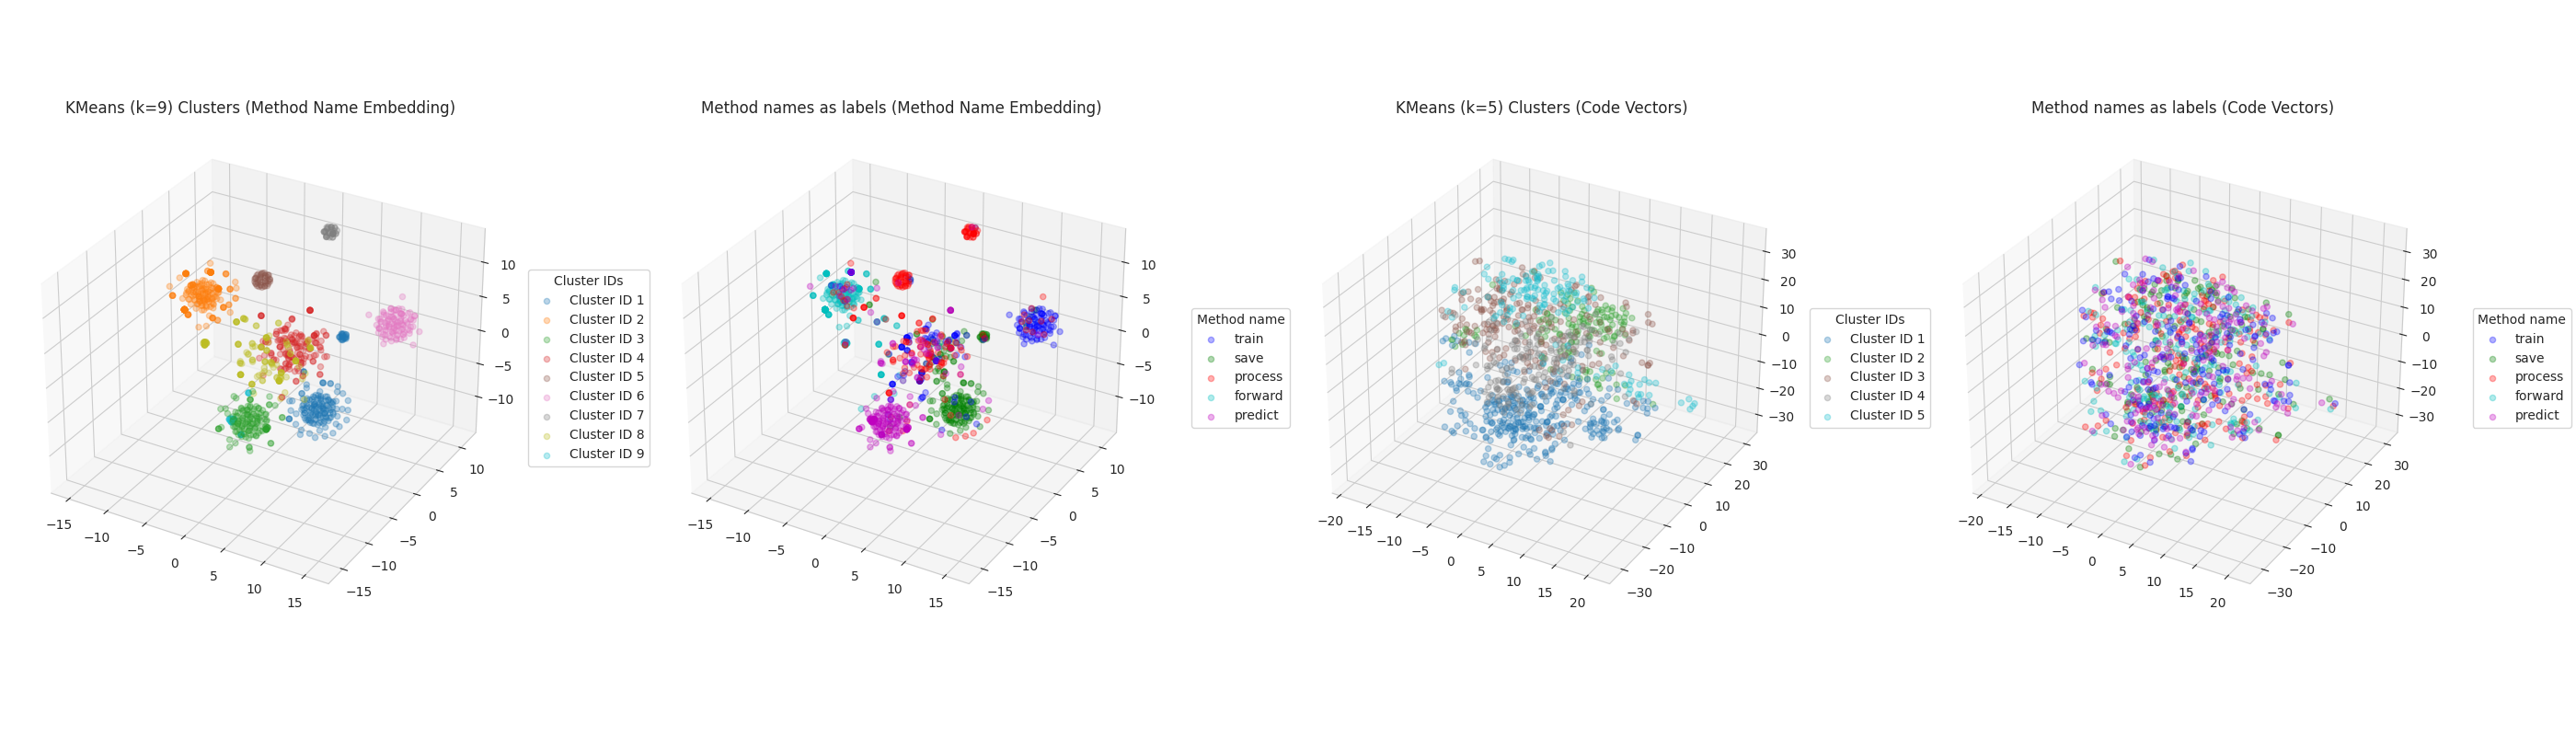

Method Name Embedding
Number of clusters: 9
Homogeneity: 0.478
Completeness: 0.380
V-measure: 0.424
Adjusted Rand Index: 0.370
Adjusted Mutual Information: 0.418
Mean Jaccard Coefficient: 0.007173023292855805
Silhouette Coefficient: 0.679
Dunn Index: 0.313

Code Vectors
Number of clusters: 5
Homogeneity: 0.007
Completeness: 0.007
V-measure: 0.007
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.002
Mean Jaccard Coefficient: 0.12450177846150859
Silhouette Coefficient: 0.330
Dunn Index: 0.117



In [28]:
# Apply K-means
search_params = {'n_clusters': np.arange(2,11)}

kmeans_results = {}

for key in datasets:
    df = datasets[key]['DataFrame']
    features = datasets[key]['Features']
    
    cv = [(slice(None), slice(None))] # Disable cv, only want grid search
    gs = GridSearchCV(estimator=KMeans(random_state=0), param_grid=search_params, 
                      scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

    res = gs.fit(X=features, y=None)
    
    max_score = np.max(res.cv_results_['mean_test_score'])
    ind = np.argmax(res.cv_results_['mean_test_score'])
    k = search_params['n_clusters'][ind]

    print(f"Best validation score {max_score:.3f} achieved with {k} clusters")
    kmeans_estimator = KMeans(n_clusters=k, random_state=0)
    kmeans_name = kmeans_estimator.__class__.__name__

    kmeans = kmeans_estimator.fit(features)
    kmeans_metrics = calculate_metrics(kmeans_estimator, df, features, kmeans.labels_)
    kmeans_results[key] = {'labels': kmeans.labels_, 'metrics': kmeans_metrics}
    
    estimators[f"{kmeans_name} on {key}"] = {'estimator': kmeans_estimator, 'score':  max_score, 'method representation': key }
    estimator_metrics[f"{kmeans_name} on {key}"] = {'Method Representation': key, 'Estimator': kmeans_name, 'Dunn Index': kmeans_metrics['dunn_index'], 'Silhouette Score': kmeans_metrics['silhouette_score'], 'Adjusted Rand Index': kmeans_metrics['adjusted_rand_score']}


plot_clusters(kmeans, kmeans_results)

### Density-Based Clustering using OPTICS

In [ ]:
# search_params = {'cluster_method': ['xi', 'dbscan'], 'xi': np.linspace(0,1,11), 'min_samples': [2,5,10,15,20,25,30], 'metric': ['minkowski', 'cosine', 'euclidean', 'sqeuclidean']}
search_params = {'xi': np.linspace(0.1,1,10), 'min_samples': [2,5,10,15,20,25,30]}
optics_results = {}

for key in datasets:
    df = datasets[key]['DataFrame']
    features = datasets[key]['Features']
    
    cv = [(slice(None), slice(None))] # Disable cv, only want grid search
    gs = GridSearchCV(estimator=OPTICS(cluster_method='xi'), param_grid=search_params, 
                      scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

    res = gs.fit(X=features, y=None)

    # Get best configuration
    max_score = np.max(res.cv_results_['mean_test_score'])
    ind = np.argmax(res.cv_results_['mean_test_score'])
    best_params = res.cv_results_['params'][ind]
    k = best_params['min_samples']
    # metric = best_params['metric']

    # Visualize best clusters
    print(f"Best validation score {max_score:.3f} achieved with {res.cv_results_['params'][ind]}")
    optics_estimator = OPTICS(cluster_method='xi', min_samples=k)
    optics_name = optics_estimator.__class__.__name__

    optics_clusters = optics_estimator.fit(features)
    optics_metrics = calculate_metrics(optics_estimator, df, features, optics_clusters.labels_[optics_clusters.ordering_])
    optics_results[key] = {'labels': optics_clusters.labels_[optics_clusters.ordering_], 'metrics': optics_metrics}
    
    estimators[f"{optics_name} on {key}"] = {'estimator': optics_estimator, 'score':  max_score, 'method representation': key }
    estimator_metrics[f"{optics_name} on {key}"] = {'Method Representation': key, 'Estimator': optics_name, 'Silhouette Score': optics_metrics['silhouette_score'], 'Dunn Index': optics_metrics['dunn_index'], 'Adjusted Rand Index': optics_metrics['adjusted_rand_score']}
    
plot_clusters(optics_clusters, optics_results)

### Agglomerative Clustering (Hierarchical)

In [ ]:
search_params = {'n_clusters': np.arange(2,11), 'linkage': ['ward', 'complete', 'average', 'single']}
# search_params = {'n_clusters': np.arange(2,11), 'linkage': ['complete', 'average', 'single'], 'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']}
agglomerative_results = {}

for key in datasets:
    df = datasets[key]['DataFrame']
    features = datasets[key]['Features']
    
    cv = [(slice(None), slice(None))] # Disable cv, only want grid search
    gs = GridSearchCV(estimator=AgglomerativeClustering(linkage='ward'), param_grid=search_params, 
                      scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

    res = gs.fit(X=features, y=None)

    # Get best configuration
    max_score = np.max(res.cv_results_['mean_test_score'])
    ind = np.argmax(res.cv_results_['mean_test_score'])
    best_params = res.cv_results_['params'][ind]
    k = best_params['n_clusters']
    linkage = best_params['linkage']

    # Visualize best clusters
    print(f"Best validation score {max_score:.3f} achieved with {res.cv_results_['params'][ind]}")
    agglomerative_estimator = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    agglomerative_name = agglomerative_estimator.__class__.__name__

    agglomerative_clusters = agglomerative_estimator.fit(features)
    agglomerative_metrics = calculate_metrics(agglomerative_clusters, df, features, agglomerative_clusters.labels_)
    
    agglomerative_results[key] = {'labels': agglomerative_clusters.labels_, 'metrics': agglomerative_metrics}
    
    estimators[f"{agglomerative_name} on {key}"] = {'estimator': agglomerative_estimator, 'score':  max_score, 'method representation': key}
    estimator_metrics[f"{agglomerative_name} on {key}"] = {'Method Representation': key, 'Estimator': agglomerative_name, 'Dunn Index': agglomerative_metrics['dunn_index'], 'Silhouette Score': agglomerative_metrics['silhouette_score'], 'Adjusted Rand Index': agglomerative_metrics['adjusted_rand_score']}
    
plot_clusters(agglomerative_clusters, agglomerative_results)

## Select best estimator

In [ ]:
scores = [val['score'] for val in estimators.values()]
ind = np.argmax(scores)
best_estimator = list(estimators.values())[ind]['estimator']
best_method_representation = list(estimators.values())[ind]['method representation']
print(f"Best cluster method and representation: {best_estimator.__class__.__name__} on {best_method_representation}\nParams:\n{best_estimator.__dict__}")

In [ ]:
# Write configs of the best estimators from each category to file
with open(f"./results/code2vec_{DATASET_NAME}_estimators_config.txt", "w") as writer:
    for conf, score in [(val['estimator'].__dict__,val['score']) for val in estimators.values()]:
        writer.write(f"Estimator config:\n{conf}\nSilhouette Score: {score}\n\n")

In [ ]:
# Write the chosen cluster metrics for the best models to table
latex_table = pd.DataFrame([d for d in estimator_metrics.values()], columns=['Method Representation','Estimator','Dunn Index', 'Silhouette Score', 'Adjusted Rand Index']).to_latex(index=False, float_format="%.3f").replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline')
with open(f"./results/tables/{DATASET_NAME}/code2vec_{DATASET_NAME}_table.tex", "w") as writer:
    writer.write(latex_table)

# Write all cluster metrics to table
latex_table = pd.DataFrame([d for d in [kmeans_metrics, optics_metrics, agglomerative_metrics]]).to_latex(index=False, float_format="%.3f").replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline')
with open(f"./results/tables/{DATASET_NAME}/code2vec_{DATASET_NAME}_all_metrics_table.tex", "w") as writer:
    writer.write(latex_table)

## Visualize Clusters with Kepler Mapper

In [ ]:
# Visualize with kepler map
mapper = km.KeplerMapper(verbose=1)

# Fit and transform data, use TSNE 
projected_data = mapper.fit_transform(datasets[best_method_representation]['Features'], projection=TSNE(n_components=2))

# Create the graph (we cluster on the projected data and suffer projection loss)
graph = mapper.map(
    projected_data,
    clusterer=best_estimator,
    cover=km.Cover(5, 0.3),
)

# Create the visualizations
print("Output graph examples to html")
mapper.visualize(
    graph,
    title=f"{DATASET_NAME} {best_method_representation} Mapper",
    path_html=f"./results/figures/{DATASET_NAME}/{DATASET_NAME}_visualization.html",
    custom_tooltips=datasets[best_method_representation]['DataFrame']['category'].values
)

jupyter.display(path_html=f"./results/figures/{DATASET_NAME}/{DATASET_NAME}_visualization.html")